**AD_spin1**

Computational Astrodynamics (ΥΦΥ204)

Implemented by: **Anastasios-Faidon Retselis (AEM: 4394)**

# Exercise 1 

## Problem statement

A satellite with "asphericity" $\epsilon=0.05$ moves in elliptic orbit around a planet ($\mu=G(m_{p}+m_{s})=1$ with semi-major axis $a=1$, eccentricity $e$ and starting point ($t=0$) at pericenter ($f=0$), i.e. $r_{0}=1-e$, and initial conditions (angles in rad):
 
(1) $\theta_{0} = 0.1, \; \dot{\theta}_{0}=1.0$

(2) $\theta_{0} = 1.57, \; \dot{\theta}_{0}=1.0$

Plot the angle $\psi(t)=f(t)-\theta(t)$ using the above initial conditions and considering $e=0$ and $e=0.3$ (integration time $0<t<t_{max}=200$). Compute FLI for all cases.

## $\psi(t)$ solution

To compute the angle $\psi(t)=f(t)-\theta(t)$, we will have to compute the angle $\theta(t)$ from the spin-orbit coupling differential equation:

$$
\begin{equation}
\ddot{\theta}+\varepsilon \frac{1}{r^{3}} \sin (2 \theta-2 f)=0
\end{equation}
$$

which we can solve using a 4th order Runge-Kutta method which is implemented below, by solving the equation as a system, namely:

$$ \dot{x}_{1}(t) = x_{2}(t) $$

$$ \dot{x}_{2}(t) = - \varepsilon \frac{1}{r^{3}} \sin (2 \theta-2 f)$$

We note in the second equation we have to compute the radius $r$ and the true anomaly $f$ for each time step. To achieve this, we will introduce a Newton-Raphson method which computes the eccentric anomaly at each time step by solving Kepler's equation $M=E-e sin(E)$. Since we have the eccentric anomaly, we can then compute the true anomaly from the equation $f=2 \arctan \left(\sqrt{\frac{1+e}{1-e}} \tan \frac{E}{2}\right)$ and the radius from the equation $r=a(1-e \cos E)$. We repeat this process for the start points, mid points and end points inside the Runge-Kutta method and we can finally compute the desired angle $\psi$ as a function of time. The time step used for the Runge-Kutta Method is $h=0.01$.

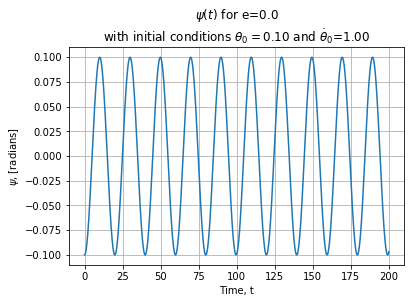

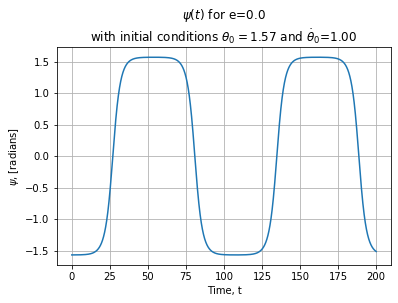

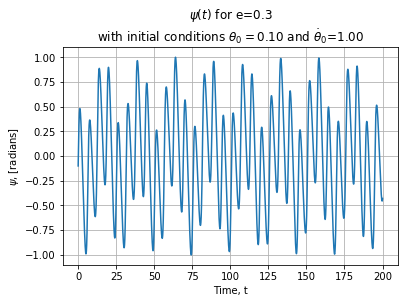

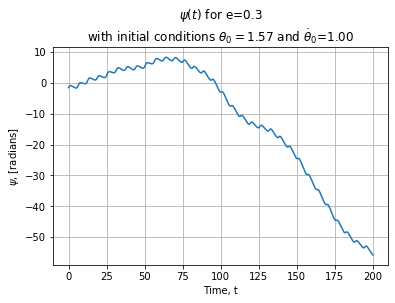

In [1]:
import numpy as np
import matplotlib.pyplot as plt
# Make jupyter export images as .pdf files for higher quality
from IPython.display import set_matplotlib_formats
set_matplotlib_formats('png', 'pdf')


def runge_kutta_4(theta_0, theta_dot_0, a, epsilon, ecc, n, tau, initial_anomaly, t_start, t_max, h):
    # 4th order Runge-Kutta method for the spin-orbit coupling problem
    # Input:
    # Initial conditions: theta_0 [rad], theta_dot_0 [rad]
    # a, semi-major axis []
    # epsilon, asphericity []
    # ecc, eccentricity []
    # n, Orbit mean motion [rad]
    # tau, time of pericenter [time units]
    # initial_anomaly, [rad]
    # t_start, initial time [time units]
    # t_max, RK4 end time [time units]
    # h, integration step size [time units]

    # Log initial values
    t_vector = [t_start]
    theta_vector = [theta_0]
    thetadot_vector = [theta_dot_0]
    psi_vector = [initial_anomaly-theta_0]
    counter = 0
    anomaly_counter = 0
    anomaly_vector = [initial_anomaly]
    # Main RK4 loop
    while t_vector[counter] < t_max:
        # Calculate k1 values
        k1_theta = f_theta(theta_dot_0)
        k1_thetadot, anomaly = f_theta_dot(theta_0, t_vector[counter], n, tau, ecc, a, epsilon)
        # Calculate midpoint values
        mid_theta = theta_0 + k1_theta * h/2
        mid_thetadot = theta_dot_0 + k1_thetadot * h/2
        # Calculate k2 values
        k2_theta = f_theta(mid_thetadot)
        k2_thetadot, anomaly = f_theta_dot(mid_theta, t_vector[counter]+h/2, n, tau, ecc, a, epsilon)
        # Calculate next midpoint values
        mid_theta = theta_0 + k2_theta * h / 2
        mid_thetadot = theta_dot_0 + k2_thetadot * h / 2
        # Calculate k3 values
        k3_theta = f_theta(mid_thetadot)
        k3_thetadot, anomaly = f_theta_dot(mid_theta, t_vector[counter]+h/2, n, tau, ecc, a, epsilon)
        # Calculate endpoint values
        mid_theta = theta_0 + k3_theta * h
        mid_thetadot = theta_dot_0 + k3_thetadot * h
        # Calculate k4 values
        k4_theta = f_theta(mid_thetadot)
        k4_thetadot, anomaly = f_theta_dot(mid_theta, t_vector[counter]+h, n, tau, ecc, a, epsilon)
        # Compute theta and theta_dot values and append to vector
        theta_vector.append(theta_vector[counter] + (h / 6) * (k1_theta + 2 * k2_theta + 2 * k3_theta + k4_theta))
        thetadot_vector.append(thetadot_vector[counter] + (h / 6) * (k1_thetadot + 2 * k2_thetadot + 2 * k3_thetadot + k4_thetadot))
        # Compute endpoint anomaly and condition for cases above 2pi
        anomaly_vector.append(anomaly+2*np.pi*anomaly_counter)
        if anomaly_vector[counter+1]-anomaly_vector[counter] < 0:
            anomaly_counter += 1
            anomaly_vector[counter + 1] += 2*np.pi
        psi_vector.append(anomaly_vector[counter+1]-theta_vector[counter+1])
        # Prepare for next iteration
        counter += 1
        t_vector.append(t_vector[counter - 1] + h)
        theta_0 = theta_vector[counter]
        theta_dot_0 = thetadot_vector[counter]
    return t_vector, psi_vector


def f_theta(theta_dot):
    # Assuming theta'(t) = theta_dot
    return theta_dot


def f_theta_dot(theta, time, n, tau, e, a, epsilon):
    # Assuming theta''(t) = -epsilon*(1/r^3)sin(2theta-2f)
    E = eccentric_anomaly_calculator(time, n, tau, e)
    ni = 2*np.arctan(np.sqrt((1+e)/(1-e))*np.tan(E/2))
    if ni < 0:
        ni += 2*np.pi
    r = a*(1-e*np.cos(E))
    return -(epsilon/pow(r, 3))*np.sin(2*theta-2*ni), ni


def eccentric_anomaly_calculator(time, n, tau, e):
    # Compute E using Newton-Raphson
    # Define initial value for E_0
    M = n * (time - tau)
    if M <np.pi:
        E_0 = M - e
    else:
        E_0 = M + e
    # Define f and f dot
    f = lambda E: M - E + e*np.sin(E)
    fdot = lambda E: -1 + e*np.cos(E)
    # Stopping criteria
    N = 15  # Number of significant digits to be computed
    max_repetitions = 1000000
    es = 0.5 * pow(10, (2 - N))  # Scarborough Criterion
    ea = 100
    E_prev = E_0
    repetitions = 0
    # Main Newton-Raphson loop
    while ea > es:
        repetitions = repetitions + 1
        E_next = E_prev - (f(E_prev) / fdot(E_prev))
        if E_next == 0:
            return E_next
        ea = np.fabs((E_next - E_prev) * 100 / E_next)
        E_prev = E_next
        if repetitions > max_repetitions:
            print('Max repetitions reached without achieving desired accuracy for E!')
            break
    E = E_next
    return E


def plot_results(x, y, e, theta_0, theta_dot_0):
    plt.figure()
    plt.plot(x, y)
    plt.title(r"$\psi(t)$ for e=%.1f" % e + "\n" +
              r"with initial conditions $\theta_{0}=$%.2f and $\dot{\theta}_{0}$=%.2f" % (theta_0, theta_dot_0))
    plt.xlabel("Time, t")
    plt.ylabel("$\psi$, [radians]")
    plt.grid()
    plt.show()


# System properties
a = 1
mu = 1
tau = 0
f_0 = 0
T = np.sqrt(4*pow(np.pi, 2)*pow(a, 3)/mu)
n = 2*np.pi/T
epsilon = 0.05

# Integration properties
start_time = 0
end_time = 200
time_step = 0.01

# Case 1
e = 0
theta_0 = 0.1
theta_dot_0 = 1.0

# Solve and plot result
time, psi_values = runge_kutta_4(theta_0, theta_dot_0, a, epsilon, e, n, tau, f_0, start_time, end_time, time_step)
plot_results(time, psi_values, e, theta_0, theta_dot_0)

# Case 2
e = 0
theta_0 = 1.57
theta_dot_0 = 1.0

# Solve and plot result
time, psi_values = runge_kutta_4(theta_0, theta_dot_0, a, epsilon, e, n, tau, f_0, start_time, end_time, time_step)
plot_results(time, psi_values, e, theta_0, theta_dot_0)

# Case 3
e = 0.3
theta_0 = 0.1
theta_dot_0 = 1.0

# Solve and plot result
time, psi_values = runge_kutta_4(theta_0, theta_dot_0, a, epsilon, e, n, tau, f_0, start_time, end_time, time_step)
plot_results(time, psi_values, e, theta_0, theta_dot_0)

# Case 4
e = 0.3
theta_0 = 1.57
theta_dot_0 = 1.0

# Solve and plot result
time, psi_values = runge_kutta_4(theta_0, theta_dot_0, a, epsilon, e, n, tau, f_0, start_time, end_time, time_step)
plot_results(time, psi_values, e, theta_0, theta_dot_0)

From the plots produced above, we note that for $\theta_{0} = 0.1$ and $\dot{\theta}_{0}=1.0$ the values of $\psi(t)$ are oscillating between 0.1 and -0.1 radians for the case of $e=0$ and between 1 and -1 radians for the case of $e=0$. It is also noted that the oscillation appears to be smoother for the $e=0$ case. For $\theta_{0} = 1.57$ and $\dot{\theta}_{0}=1.0$, we note that in the case of $e=0$ the values of $\psi$ are oscillating with a larger period between $\pi/2$ and $-\pi/2$. For the $e=0.3$ case, the values of $\psi$ initially begin to rise and then start falling, indicating that the satellite is rotating and is no longer performing the constrained oscillations observed for the other 3 cases.

## FLI solution

We will now compute the Fast Lyapunov indicator for all three cases. FLI is given by the equation:

$$
F L I(t)=\log \left(\sqrt{\xi(t)^{2}+\eta(t)^{2}}\right)
$$

where $\xi$ and $\eta$ is the system resulting from the realization of the original system. It follows that the linearized system for this problem is:

$$\dot{\xi}(t)=\eta(t)$$

$$\dot{\eta}(t)= - \varepsilon \frac{2}{r^{3}} \cos (2 \theta-2 f)\xi$$

We can thus extend our original 4th order Runge-Kutta routine to include these two extra differential equations and solve the system of the four differential equations. At the end of each time step, we will compute the Fast Lyapunov Indicator (FLI) and plot it at the end.

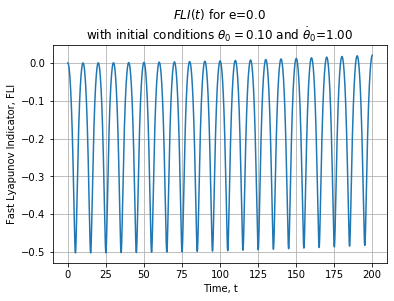

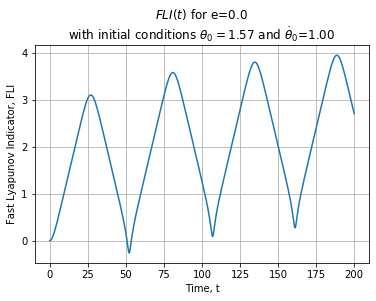

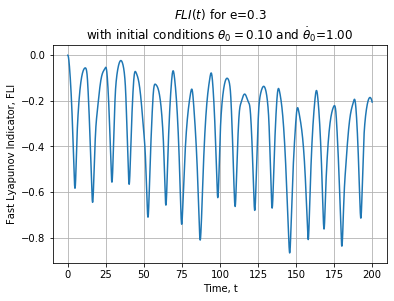

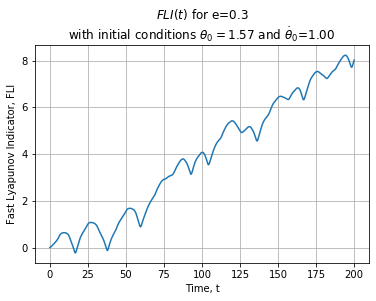

In [2]:
import numpy as np
import matplotlib.pyplot as plt
# Make jupyter export images as .pdf files for higher quality
from IPython.display import set_matplotlib_formats
set_matplotlib_formats('png', 'pdf')


def runge_kutta_4(theta_0, theta_dot_0, a, epsilon, ecc, n, tau, initial_anomaly, t_start, t_max, h):
    # 4th order Runge-Kutta method for the spin-orbit coupling problem
    # Returns time vector and Fast Lyapunov Indicator
    # Input:
    # Initial conditions: theta_0 [rad], theta_dot_0 [rad]
    # a, semi-major axis []
    # epsilon, asphericity []
    # ecc, eccentricity []
    # n, Orbit mean motion [rad]
    # tau, time of pericenter [time units]
    # initial_anomaly, [rad]
    # t_start, initial time [time units]
    # t_max, RK4 end time [time units]
    # h, integration step size [time units]

    # Log initial values
    t_vector = [t_start]
    theta_vector = [theta_0]
    thetadot_vector = [theta_dot_0]
    psi_vector = [initial_anomaly-theta_0]
    xi_vector = [1]
    eta_vector = [0]
    xi_0 = xi_vector[0]
    eta_0 = eta_vector[0]
    fli_vector = [np.log10(pow(xi_vector[0], 2) + pow(eta_vector[0], 2))/2]
    counter = 0
    anomaly_counter = 0
    anomaly_vector = [initial_anomaly]
    # Main RK4 loop
    while t_vector[counter] < t_max:
        # Calculate k1 values
        k1_theta = f_theta(theta_dot_0)
        k1_thetadot, anomaly = f_theta_dot(theta_0, t_vector[counter], n, tau, ecc, a, epsilon)
        k1_xi = f_xi(eta_0)
        k1_eta = f_eta(theta_0, t_vector[counter], n, tau, e, a, epsilon, xi_0)
        # Calculate midpoint values
        mid_theta = theta_0 + k1_theta * h/2
        mid_thetadot = theta_dot_0 + k1_thetadot * h/2
        mid_xi = xi_0 + k1_xi * h/2
        mid_eta = eta_0 + k1_eta * h/2
        # Calculate k2 values
        k2_theta = f_theta(mid_thetadot)
        k2_thetadot, anomaly = f_theta_dot(mid_theta, t_vector[counter]+h/2, n, tau, ecc, a, epsilon)
        k2_xi = f_xi(mid_eta)
        k2_eta = f_eta(mid_theta, t_vector[counter]+h/2, n, tau, e, a, epsilon, mid_xi)
        # Calculate next midpoint values
        mid_theta = theta_0 + k2_theta * h / 2
        mid_thetadot = theta_dot_0 + k2_thetadot * h / 2
        mid_xi = xi_0 + k2_xi * h / 2
        mid_eta = eta_0 + k2_eta * h / 2
        # Calculate k3 values
        k3_theta = f_theta(mid_thetadot)
        k3_thetadot, anomaly = f_theta_dot(mid_theta, t_vector[counter]+h/2, n, tau, ecc, a, epsilon)
        k3_xi = f_xi(mid_eta)
        k3_eta = f_eta(mid_theta, t_vector[counter] + h / 2, n, tau, e, a, epsilon, mid_xi)
        # Calculate endpoint values
        mid_theta = theta_0 + k3_theta * h
        mid_thetadot = theta_dot_0 + k3_thetadot * h
        mid_xi = xi_0 + k2_xi * h
        mid_eta = eta_0 + k2_eta * h
        # Calculate k4 values
        k4_theta = f_theta(mid_thetadot)
        k4_thetadot, anomaly = f_theta_dot(mid_theta, t_vector[counter]+h, n, tau, ecc, a, epsilon)
        k4_xi = f_xi(mid_eta)
        k4_eta = f_eta(mid_theta, t_vector[counter] + h, n, tau, e, a, epsilon, mid_xi)
        # Compute theta and theta_dot values and append to vector
        theta_vector.append(theta_vector[counter] + (h / 6) * (k1_theta + 2 * k2_theta + 2 * k3_theta + k4_theta))
        thetadot_vector.append(thetadot_vector[counter] + (h / 6) * (k1_thetadot + 2 * k2_thetadot + 2 * k3_thetadot + k4_thetadot))
        eta_vector.append(eta_vector[counter] + (h / 6) * (k1_eta + 2 * k2_eta + 2 * k3_eta + k4_eta))
        xi_vector.append(xi_vector[counter] + (h / 6) * (k1_xi + 2 * k2_xi + 2 * k3_xi + k4_xi))
        # Compute endpoint anomaly and condition for cases above 2pi
        anomaly_vector.append(anomaly+2*np.pi*anomaly_counter)
        if anomaly_vector[counter+1]-anomaly_vector[counter] < 0:
            anomaly_counter += 1
            anomaly_vector[counter + 1] += 2*np.pi
        fli_vector.append(np.log10(pow(eta_vector[counter+1], 2) + pow(xi_vector[counter+1], 2))/2)
        psi_vector.append(anomaly_vector[counter+1]-theta_vector[counter+1])
        # Prepare for next iteration
        counter += 1
        t_vector.append(t_vector[counter - 1] + h)
        theta_0 = theta_vector[counter]
        theta_dot_0 = thetadot_vector[counter]
        eta_0 = eta_vector[counter]
        xi_0 = xi_vector[counter]
    return t_vector, fli_vector


def f_theta(theta_dot):
    # Assuming theta'(t) = theta_dot
    return theta_dot


def f_theta_dot(theta, time, n, tau, e, a, epsilon):
    # Assuming theta''(t) = -epsilon*(1/r^3)sin(2theta-2f)
    E = eccentric_anomaly_calculator(time, n, tau, e)
    ni = 2*np.arctan(np.sqrt((1+e)/(1-e))*np.tan(E/2))
    if ni < 0:
        ni += 2*np.pi
    r = a*(1-e*np.cos(E))
    return -(epsilon/pow(r, 3))*np.sin(2*theta-2*ni), ni


def f_xi(eta):
    # Assuming xi'(t) = eta
    return eta


def f_eta(theta, time, n, tau, e, a, epsilon, xi):
    E = eccentric_anomaly_calculator(time, n, tau, e)
    ni = 2 * np.arctan(np.sqrt((1 + e) / (1 - e)) * np.tan(E / 2))
    if ni < 0:
        ni += 2 * np.pi
    r = a * (1 - e * np.cos(E))
    # Assuming eta'(t) = -2*epsilon*(1/r^3)*cos(2theta-2f)*xi
    return -(2*epsilon / pow(r, 3)) * np.cos(2 * theta - 2 * ni) * xi


def eccentric_anomaly_calculator(time, n, tau, e):
    # Compute E using Newton-Raphson
    # Define initial value for E_0
    M = n * (time - tau)
    if M <np.pi:
        E_0 = M - e
    else:
        E_0 = M + e
    # Define f and f dot
    f = lambda E: M - E + e*np.sin(E)
    fdot = lambda E: -1 + e*np.cos(E)
    # Stopping criteria
    N = 15  # Number of significant digits to be computed
    max_repetitions = 1000000
    es = 0.5 * pow(10, (2 - N))  # Scarborough Criterion
    ea = 100
    E_prev = E_0
    repetitions = 0
    # Main Newton-Raphson loop
    while ea > es:
        repetitions = repetitions + 1
        E_next = E_prev - (f(E_prev) / fdot(E_prev))
        if E_next == 0:
            return E_next
        ea = np.fabs((E_next - E_prev) * 100 / E_next)
        E_prev = E_next
        if repetitions > max_repetitions:
            print('Max repetitions reached without achieving desired accuracy for E!')
            break
    E = E_next
    return E


def plot_results(x, y, e, theta_0, theta_dot_0):
    plt.figure()
    plt.plot(x, y)
    plt.title(r"$FLI(t)$ for e=%.1f" % e + "\n" +
              r"with initial conditions $\theta_{0}=$%.2f and $\dot{\theta}_{0}$=%.2f" % (theta_0, theta_dot_0))
    plt.ylabel("Fast Lyapunov Indicator, FLI")
    plt.xlabel("Time, t")
    plt.grid()
    plt.show()


# System properties
a = 1
mu = 1
tau = 0
f_0 = 0
T = np.sqrt(4*pow(np.pi, 2)*pow(a, 3)/mu)
n = 2*np.pi/T
epsilon = 0.05

# Integration properties
start_time = 0
end_time = 200
time_step = 0.01

# Case 1
e = 0
theta_0 = 0.1
theta_dot_0 = 1.0

# Solve and plot result
time, fli_values = runge_kutta_4(theta_0, theta_dot_0, a, epsilon, e, n, tau, f_0, start_time, end_time, time_step)
plot_results(time, fli_values, e, theta_0, theta_dot_0)

# Case 2
e = 0
theta_0 = 1.57
theta_dot_0 = 1.0

# Solve and plot result
time, fli_values = runge_kutta_4(theta_0, theta_dot_0, a, epsilon, e, n, tau, f_0, start_time, end_time, time_step)
plot_results(time, fli_values, e, theta_0, theta_dot_0)

# Case 3
e = 0.3
theta_0 = 0.1
theta_dot_0 = 1.0

# Solve and plot result
time, fli_values = runge_kutta_4(theta_0, theta_dot_0, a, epsilon, e, n, tau, f_0, start_time, end_time, time_step)
plot_results(time, fli_values, e, theta_0, theta_dot_0)

# Case 4
e = 0.3
theta_0 = 1.57
theta_dot_0 = 1.0

# Solve and plot result
time, fli_values = runge_kutta_4(theta_0, theta_dot_0, a, epsilon, e, n, tau, f_0, start_time, end_time, time_step)
plot_results(time, fli_values, e, theta_0, theta_dot_0)

We can immediately observe that for initial conditions $\theta_{0} = 0.1$ and $\dot{\theta}_{0}=1.0$ the values of the Fast Lyapunov Indicator appear to have an almost constant average value and that they rise with a very slow case, indicating that we have a normal behavior. However, for the final case with $\theta_{0} = 1.57$ and $\dot{\theta}_{0}=1.0$ and $e=0.3$, we can immediately observe that the values of the Fast Lyapunov Indicator quickly start rising. If we compute the FLI for a larger time interval, we can determine that this trend continues and the indicator continues to rise quickly, indicating that for this system we have a chaotic behavior.  